In [1]:
from pathlib import Path
import sys
import os
import shutil
import random

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, "./preprocessing")
from preprocessing.isochrones import (
    read_matrix_to_df,
    merge_traveltimes_to_grid,
    dissolve_grid_to_isochrones,
)
from preprocessing.config import (
    TRAVEL_MODES,
    BREAKPOINTS,
)
from preprocessing.minify_geodataframe import minify_geodataframe
from preprocessing.minify_geojson import minify_files_in_dir

In [2]:
GRID_DIR = Path("./data/Helsinki_Travel_Time_Matrix_2023_grid.gpkg.zip")
TTM_DIR = Path("./data/Helsinki_Travel_Time_Matrix_2023")
TEST_DIR = Path("./data/test/")

SAMPLE_SIZE = 100  # How many grid cells to pick

ttm_paths = list(TTM_DIR.rglob("*.csv"))
ttm_paths = random.sample(ttm_paths, SAMPLE_SIZE)

grid = gpd.read_file(GRID_DIR)
grid = grid[["id", "geometry"]].to_crs(epsg=4326)


def init_empty_dir(dir: Path):
    if dir.exists() and dir.is_dir():
        shutil.rmtree(dir)
    dir.mkdir(parents=True, exist_ok=True) 
    return dir
    #[print(path) for path in directory.iterdir()]


def get_avg_file_size_per_cell(dir: Path, cell_count, humanized=False):
    bytes = sum(i.stat().st_size for i in dir.iterdir() if i.is_file())
    bytes_per_cell = bytes / SAMPLE_SIZE
    print(bytes_per_cell)
    if humanized:
        for unit in ("", "K", "M", "G", "T", "P", "E", "Z"):
            if abs(bytes_per_cell) < 1000:
                return f"{bytes_per_cell:3.1f} {unit}B"
            bytes_per_cell /= 1000
    return bytes_per_cell

def plot_isochrones(isochrones, grid):
    fig, ax = plt.subplots(figsize=(10, 6))

    grid.dissolve().plot(ax=ax, color="lightgray")
    isochrones.plot(
        ax=ax,
        column="t",
        legend=True,
        categorical=True,
        cmap="cividis_r",
    )

In [3]:
# csv-only file-sizes
write_dir = init_empty_dir(TEST_DIR)

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        traveltimes[[mode]].to_csv(Path(write_dir / f"{i}_{mode}.csv"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

1821874.66
1.8 MB


In [4]:
# This cell writes the traveltimes joined to yrk grid as is, without any simplification
# It is there just to see the worst-case scenario

i_have_time = False  # It will take a lot of time to run this for larger sample sizes

if i_have_time:
    write_dir = init_empty_dir(TEST_DIR)
    
    for i, path in enumerate(ttm_paths):
        traveltimes = read_matrix_to_df(
            path,
            filetype="csv"
        )
        for mode in TRAVEL_MODES:
            tt_grid = merge_traveltimes_to_grid(
                grid,
                traveltimes,
                mode,
            )
            tt_grid.to_file(Path(write_dir / f"{i}_{mode}.geojson"))
    
    print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

In [5]:
write_dir = init_empty_dir(TEST_DIR)

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        tt_grid = merge_traveltimes_to_grid(
            grid,
            traveltimes,
            mode,
        )
        tt_isochrones = dissolve_grid_to_isochrones(
            tt_grid,
            breakpoints=BREAKPOINTS,
            mode=mode,
        )
        tt_isochrones.to_file(Path(write_dir / f"{i}_{mode}.geojson"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

1643070.97
1.6 MB


In [6]:
write_dir = init_empty_dir(TEST_DIR)

grid_minified = minify_geodataframe(grid, epsg=4326, coordinate_precision=5)

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        tt_grid = merge_traveltimes_to_grid(
            grid_minified,
            traveltimes,
            mode,
        )
        tt_isochrones = dissolve_grid_to_isochrones(
            tt_grid,
            breakpoints=BREAKPOINTS,
            mode=mode,
        )
        tt_isochrones.to_file(Path(write_dir / f"{i}_{mode}.geojson"))

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

/var/home/eemil/repos/travel-time-matrix-visualisation-preprocessing/.venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


901016.82
901.0 KB


In [7]:
minify_files_in_dir(write_dir, logging=False)
print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

744676.22
744.7 KB


In [8]:
# This cell will fail on windows

import subprocess

subprocess.run(
    ["./compress", "data/test"],  # Or if the compress script is not executable
    stdout = subprocess.DEVNULL,
    stderr = subprocess.DEVNULL
)

print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

201036.94
201.0 KB


In [9]:
def percentage(x, y):
    return int(x / y * 100)

grid_minified = minify_geodataframe(grid, epsg=3067, coordinate_precision=5)

grid_area = int(grid_minified["geometry"].area.sum())
print(grid_area)

mode_results = {mode: [] for mode in TRAVEL_MODES}

total_isochrone_area = 0

for i, path in enumerate(ttm_paths):
    traveltimes = read_matrix_to_df(
        path,
        filetype="csv"
    )
    for mode in TRAVEL_MODES:
        tt_grid = merge_traveltimes_to_grid(
            grid_minified,
            traveltimes,
            mode,
        )
        tt_isochrones = dissolve_grid_to_isochrones(
            tt_grid,
            breakpoints=BREAKPOINTS,
            mode=mode,
        )
        area = int(tt_isochrones["geometry"].area.sum())
        mode_results[mode].append(area)
        total_isochrone_area += area

all_modes_avg = total_isochrone_area / (SAMPLE_SIZE * len(TRAVEL_MODES))
all_modes_percentage = percentage(all_modes_avg, grid_area)

mode_avgs = {mode: sum(results) / len(results) for mode, results in mode_results.items()}
mode_avg_percentages = {mode: percentage(avg_area, grid_area) for mode, avg_area in mode_avgs.items()}

#print(get_avg_file_size_per_cell(write_dir, cell_count=SAMPLE_SIZE, humanized=True))

/var/home/eemil/repos/travel-time-matrix-visualisation-preprocessing/.venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


826937499


In [10]:
mode_avg_percentages

{'walk_avg': 3,
 'walk_slo': 1,
 'bike_fst': 36,
 'bike_avg': 27,
 'bike_slo': 18,
 'car_r': 98,
 'car_m': 98,
 'car_n': 98,
 'pt_r_walk_avg': 29,
 'pt_m_walk_avg': 28,
 'pt_n_walk_avg': 3}

In [11]:
all_modes_percentage

40

pt_m_walk_avg 5872461


/var/home/eemil/repos/travel-time-matrix-visualisation-preprocessing/.venv/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


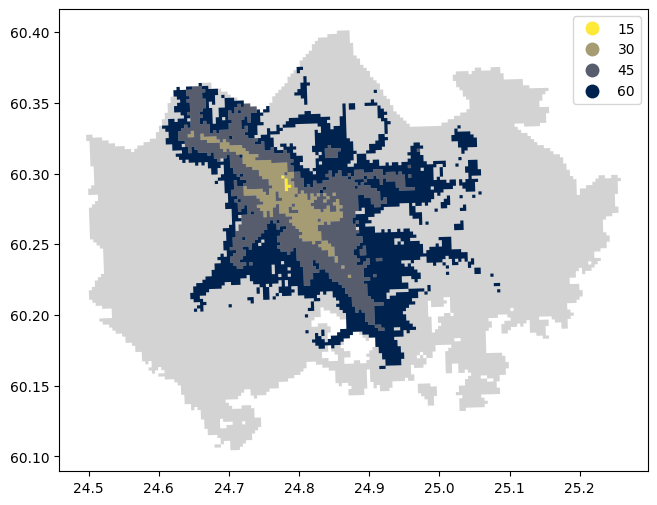

In [12]:
# A cell you can spam to see randomly generated isochrones

ykr_id = grid.sample().iloc[0]["id"]  # random ykr id
mode = random.choice(TRAVEL_MODES)    # random mode
breakpoints = [15, 30, 45, 60]        # isochrones

print(mode, ykr_id)

traveltimes = read_matrix_to_df(
    Path(f"./data/Helsinki_Travel_Time_Matrix_2023/Helsinki_Travel_Time_Matrix_2023_travel_times_to_{ykr_id}.csv"),
    filetype="csv"
)

tt_grid = merge_traveltimes_to_grid(
    grid,
    traveltimes,
    mode,
)

tt_isochrones = dissolve_grid_to_isochrones(
    tt_grid,
    breakpoints=breakpoints,
    mode=mode,
)

plot_isochrones(tt_isochrones, grid)